In [171]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from algbench import read_as_pandas, Benchmark
import re

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [9, 3.5]

In [172]:
algorithm_mapping = {
    "combo": "COMBO",
    "cp-sat": "CP-SAT",
    "expknap": "Expknap",
    "greedy": "Greedy",
    "ip": "IP",
    "qtg": "QTG"
}
hue_order = [algorithm_mapping["combo"],
             algorithm_mapping["ip"],
             algorithm_mapping["cp-sat"],
             algorithm_mapping["greedy"],
             algorithm_mapping["qtg"]]

In [176]:
combo_results = read_as_pandas('results/classical_benchmark/easy', lambda row: {
    'algorithm': algorithm_mapping[row['parameters']['args']['solver']],
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': row['result']['elapsed_cycles'],
    'instance': row['parameters']['args']['instance']['name'],
    'objective_value': row['result']['objective_value']
} if row['parameters']['args']['solver'] == "combo" else None)

optimal_solutions = dict()
for i, row in combo_results.iterrows():
    optimal_solutions[row['instance']] = row['objective_value']

qtg_results = read_as_pandas('results/quantum_benchmark', lambda row: {
    'algorithm': 'QTG',
    'size': row['parameters']['args']['instance']['size'],
    'elapsed_cycles': np.average([measure['cycle_count'] for measure in row['result']['measurements']]) +
    np.average([measure['cycle_count_decomp'] for measure in row['result']['measurements']]),
    'qubit_count': np.average([measure['qubit_count'] for measure in row['result']['measurements']]),
    'average_gap': np.average([
        (optimal_solutions[row['parameters']['args']['instance']['name']] - 
        measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'best_gap': np.min([
        (optimal_solutions[row['parameters']['args']['instance']['name']] - 
        measure['objective_value']) / optimal_solutions[row['parameters']['args']['instance']['name']]
        for measure in row['result']['measurements']]),
    'instance': row['parameters']['args']['instance']['name']
})

elapsed_cycles_comparison = pd.concat([combo_results, qtg_results])
elapsed_cycles_comparison['g'] = elapsed_cycles_comparison.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)

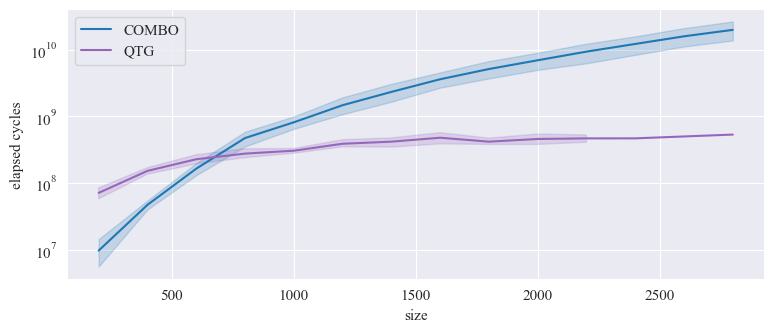

In [177]:
fig, ax = plt.subplots()
sns.lineplot(elapsed_cycles_comparison, x='size', y='elapsed_cycles', hue='algorithm', hue_order=hue_order, ax=ax)
ax.set_yscale('log')
ax.set_ylabel("elapsed cycles")
legend = ax.legend()
texts = [algo.get_text() for algo in legend.get_texts()]
lines = legend.get_lines()
ax.legend(lines[0:1]+lines[4:5], texts[0:1]+texts[4:5])
plt.show()

In [184]:
greedy_memory = dict()
for row in Benchmark('results/classical_benchmark/easy'):
    if row['parameters']['args']['solver'] == "greedy":
        greedy_memory[row['parameters']['args']['instance']['size']] = (
                row['result']['maximum_resident_size_kb'] * 1024 * 8)

other_results = read_as_pandas('results/classical_benchmark/easy', lambda row: {
    'algorithm': algorithm_mapping[row['parameters']['args']['solver']],
    'size': row['parameters']['args']['instance']['size'],
    'memory_bits': max(0, row['result']['maximum_resident_size_kb'] * 1024 * 8 - greedy_memory[
        row['parameters']['args']['instance']['size']]) + row['parameters']['args']['instance']['size'] * 32,
    # to bytes -> to bits
    'instance': row['parameters']['args']['instance']['name']
} if row['parameters']['args']['solver'] not in ["expknap"] else None)

qtg_results['memory_bits'] = qtg_results['qubit_count']

memory_comparison = pd.concat([other_results, qtg_results])

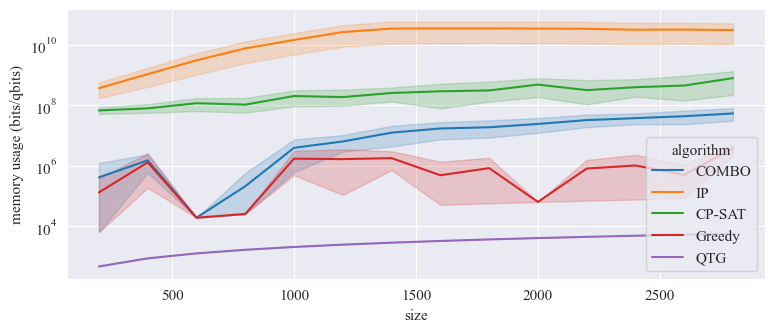

In [185]:
fig, ax = plt.subplots()
sns.lineplot(memory_comparison, x='size', y='memory_bits', hue='algorithm', hue_order=hue_order, ax=ax)
ax.set_yscale('log')
ax.set_ylabel("memory usage (bits/qbits)")
plt.show()

In [186]:
memory_comparison[memory_comparison["algorithm"] == "combo"]["memory_bits"]

Series([], Name: memory_bits, dtype: float64)

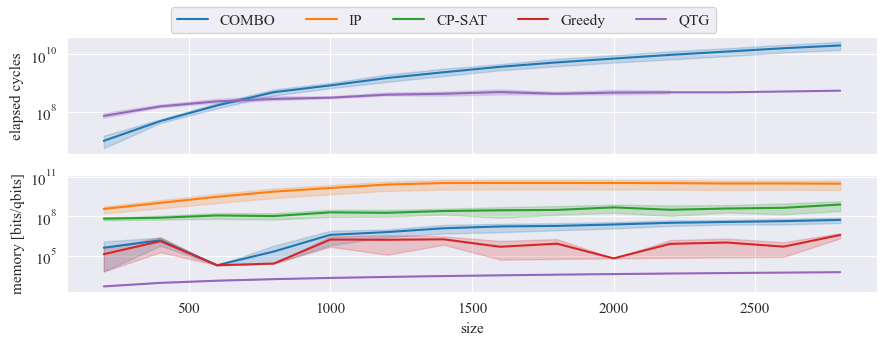

In [187]:
fig, axs = plt.subplots(nrows=2)
ax = axs[0]
sns.lineplot(elapsed_cycles_comparison, x='size', y='elapsed_cycles', hue='algorithm', hue_order=hue_order, ax=ax)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_yscale('log')
ax.set_ylabel("elapsed cycles")

ax = axs[1]
sns.lineplot(memory_comparison, x='size', y='memory_bits', hue='algorithm', hue_order=hue_order, ax=ax)
ax.set_yscale('log')
ax.set_ylabel("memory [bits/qbits]")

legend = fig.legend()
texts = [algo.get_text() for algo in legend.get_texts()]
lines = legend.get_lines()
legend.remove()

fig.legend(lines[:len(hue_order)], texts[:len(hue_order)], loc='upper center', ncol=5)

axs[0].legend().remove()
axs[1].legend().remove()

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.savefig('out/05_qtg_cycles_memory.pdf', bbox_inches='tight')

plt.show()

/var/folders/tp/x38cpg5x7zd2p54xjvncbjtm0000gn/T/ipykernel_83612/4169204089.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


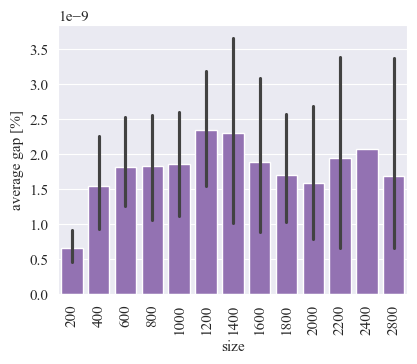

In [182]:
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.barplot(qtg_results, x='size', y='average_gap', ax=ax,  color='C4')
ax.set_ylabel("average gap [%]")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

#ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

fig.savefig("out/05_qtg_average_gap.pdf", bbox_inches='tight')
plt.show()